In [61]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as sp
import matplotlib.pyplot as plt
import json
import logging
import warnings
import os
import shutil 
import subprocess
import time

warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)


# Function to get the current git tag
def get_git_tag():
        try:
            tag = subprocess.check_output(["git", "describe", "--tags"], stderr=subprocess.DEVNULL).strip().decode()
            return tag
        except subprocess.CalledProcessError:
            return "No tag found"

def create_directories(*paths):
    """Creates multiple directories if they don't exist."""
    for path in paths:
        os.makedirs(path)


def plot_and_save_all_metrics(df_results, sampler_colors, varying_attribute, varying_attribute_for_plot, results_folder, plots_folder, run_id, config_descr):
    """
    Generates and saves multiple metric plots for different samplers.

    Parameters:
    - df_results: DataFrame containing experiment results.
    - sampler_colors: Dictionary mapping sampler names to colors.
    - varying_attribute: The attribute that varies.
    - varying_attribute_for_plot: The attribute used for plotting.
    - plots_folder: Folder where plots should be saved.
    - run_id: ID of the current run.
    - config_descr: Description of the configuration.
    """
    
    # Define metric labels
    metrics = ["wasserstein_distance", "r_hat", "ess", "runtime"]

    # Initialize plots for all metrics
    fig_ax_pairs = {key: plt.subplots(figsize=(10, 6)) for key in metrics}

    # Iterate over samplers and plot all metrics
    for sampler in df_results["sampler"].unique():
        df_sampler = df_results[df_results["sampler"] == sampler]
        csv_filename = os.path.join(results_folder, f"{sampler}_results.csv")
        df_sampler.to_csv(csv_filename, index=False)

        for metric in metrics:
            fig, ax = fig_ax_pairs[metric]
            ax.plot(df_sampler[varying_attribute_for_plot], df_sampler[metric], 
                    marker="o", linestyle="-", label=sampler, 
                    color=sampler_colors.get(sampler, "black"))

    # Set dynamic axis labels and save plots
    attribute_label = "Mode Distance" if varying_attribute == "mode_means" else varying_attribute.replace("_", " ").title()

    for metric in metrics:
        fig, ax = fig_ax_pairs[metric]
        finalize_and_save_plot(fig,ax, attribute_label, metric, 
                               f"{metric} for Samplers (config =_{config_descr})",
                               os.path.join(plots_folder, f"{metric}_run_{run_id}.pdf"))




def compute_and_save_global_metrics(df_all_runs, sampler_colors, varying_attribute, runs, config_descr, global_results_folder, global_plots_folder):
    """
    Computes and saves global metric plots (averaged across runs) for different samplers.

    Parameters:
    - df_all_runs: DataFrame containing results from all runs.
    - sampler_colors: Dictionary mapping sampler names to colors.
    - varying_attribute: The attribute that varies.
    - runs: Number of experiment runs.
    - config_descr: Configuration description.
    - global_results_folder: Folder to save CSVs.
    - global_plots_folder: Folder to save plots.
    """

    # Handle varying attributes for plotting
    if varying_attribute == "mode_means":
        df_all_runs["mode_distance"] = df_all_runs[varying_attribute].apply(lambda x: abs(eval(x)[1] - eval(x)[0]))
        df_all_runs = df_all_runs.sort_values("mode_distance", ascending=True)
        varying_attribute_for_plot = "mode_distance"
    else:
        df_all_runs = df_all_runs.sort_values(varying_attribute, ascending=True)
        varying_attribute_for_plot = varying_attribute

    # Define metrics for aggregation
    metrics = ["wasserstein_distance", "r_hat", "ess", "runtime"]

    # Initialize global plots
    fig_ax_pairs = {metric: plt.subplots(figsize=(10, 6)) for metric in metrics}

    for sampler in df_all_runs["sampler"].unique():
        df_sampler = df_all_runs[df_all_runs["sampler"] == sampler]
        color = sampler_colors.get(sampler, "black")


        # Pivot tables: rows = varying attribute, columns = run_id, values = metric
        df_pivot = {metric: df_sampler.pivot_table(index=varying_attribute_for_plot, columns="run_id", values=metric)
                    for metric in metrics}

        # Compute mean and standard deviation
        metric_stats = {metric: (df_pivot[metric].mean(axis=1), df_pivot[metric].std(axis=1))
                        for metric in metrics}

        for metric, (mean, std) in metric_stats.items():
            fig, ax = fig_ax_pairs[metric]
            ax.errorbar(mean.index, mean, yerr=std, fmt="o-", label=sampler, color=color, capsize=5)

        # Save global averages CSV
        df_global_avg = pd.DataFrame({
            varying_attribute: metric_stats["wasserstein_distance"][0].index,
            **{f"global_avg_{metric}": metric_stats[metric][0].values for metric in metrics},
            **{f"global_avg_{metric}_std": metric_stats[metric][1].values for metric in metrics},
        })


        csv_filename = os.path.join(global_results_folder, f"Global_results_{sampler}.csv")
        df_global_avg.to_csv(csv_filename, index=False)

    # Save plots
    attribute_label = "Mode Distance" if varying_attribute == "mode_means" else varying_attribute.replace("_", " ").title()
    for metric in metrics:
        fig, ax = fig_ax_pairs[metric]
        finalize_and_save_plot(fig, ax, attribute_label, metric,
                               f"Averaged {metric.replace('_', ' ').title()} ({runs} Runs, config = {config_descr})",
                               os.path.join(global_plots_folder, f"{metric}_global_plot.pdf"))



def finalize_and_save_plot(fig, ax, xlabel, ylabel, title, save_path):
    """
    Finalizes the plot with labels, grid, and saves it to a file.
    
    Parameters:
    - fig: Matplotlib figure
    - ax: Matplotlib axis
    - xlabel: Label for x-axis
    - ylabel: Label for y-axis
    - title: Title of the plot
    - save_path: Path to save the figure.
    """
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(title="Sampler")
    ax.grid(True)
    fig.savefig(save_path, bbox_inches="tight")
    plt.close(fig)



def plot_histogram(samples, title, save_path=None, posterior_type=None):
    """
    Plots a histogram and KDE of the given samples.

    Parameters:
    - samples: 1D or 2D array of samples.
    - title: Title of the plot.
    - save_path: If provided, saves the figure to this path.
    """
    plt.figure(figsize=(8, 6))

    if samples.ndim == 2:
        # Handle multivariate case
        if samples.shape[1] == 2:
            plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3, label="2D Samples")
            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.title(title)
            plt.legend()
            plt.grid(True)
        elif posterior_type == "MvNormal" and samples.shape[1] > 2:
            print(f"Skipping plotting: Multivariate Normal with dimension {samples.shape[1]}.")
            return
        
    else:
        # Standard 1D histogram + KDE
        plt.hist(samples, bins=50, alpha=0.5, density=True, color='blue', edgecolor='black', label="Histogram")
        sns.kdeplot(samples, color='red', lw=2, label="KDE")
        plt.title(title)
        plt.xlabel("Sample Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()
    else:
        plt.show()



def generate_iid_samples(posterior_type = None, num_samples=2000, rng=None,**params):
    """
    Generate IID samples from a mixture distribution.

    Parameters:
    - component_types: List of strings specifying the type of each component (e.g., ["normal", "beta"]).
    - component_params: List of dictionaries with parameters for each component.
    - num_samples: Number of samples to generate.
    - weights: List of weights for the components.
    - rng: Random number generator.

    Returns:
    - iid_samples: Array of generated IID samples.
    """

    rng = rng or np.random.default_rng()

    # Mapping from string names to scipy sampling functions
    scipy_distributions = {
        "Normal": lambda p: sp.norm.rvs(loc=p["mu"], scale=p["sigma"], size=num_samples, random_state=rng),
        "StudentT": lambda p: sp.t.rvs(df=p["nu"], loc=p["mu"], scale=p["sigma"], size=num_samples, random_state=rng),
        "Beta": lambda p: sp.beta.rvs(a=p["a"], b=p["b"], size=num_samples, random_state=rng),
        "Cauchy": lambda p: sp.cauchy.rvs(loc=p["loc"], scale=p["scale"], size=num_samples, random_state=rng),
        "Laplace": lambda p: sp.laplace.rvs(loc=p["mu"], scale=p["b"], size=num_samples, random_state=rng),
        "MvNormal": lambda p: rng.multivariate_normal(mean=np.array(p["mu"]), cov=np.array(p["cov"]), size=num_samples),
    }

    # Handle Skewed Student-T (which needs PyMC)
    if posterior_type == "SkewStudentT":
        with pm.Model():
            skewed_t = pm.SkewStudentT.dist(a=params["a"], b=params["b"], mu=params["mu"], sigma=params["sigma"])
            return pm.draw(skewed_t, draws=num_samples, random_seed=rng)

    # Handle single distributions
    if posterior_type in scipy_distributions:
        print(f"Generating {posterior_type} samples...", params)
        return scipy_distributions[posterior_type](params)

    elif posterior_type == "Mixture":
        component_types = params["component_types"]
        component_params = params["component_params"]
        weights = params["weights"]

        if len(component_types) != len(component_params):
            raise ValueError("Each component type must have a corresponding parameter dictionary.")

        # normalize weights
        weights = np.array(weights) / np.sum(weights)

        # Choose which component each sample belongs to based on weights
        chosen_components = rng.choice(len(component_types), size=num_samples, p=weights)

        posterior_dim = None  

        # Check if all components have the same dimension
        for comp_params in component_params:
            first_param = next(iter(comp_params))  # Get first parameter of current component
            first_value = comp_params[first_param]  # Get its value
            comp_dim = len(first_value) if isinstance(first_value, (np.ndarray, list)) else 1 # Get dimensionality of the first parameter

            if posterior_dim is None:
                posterior_dim = comp_dim  # Set the posterior dimension based on the first component
               
            elif comp_dim != posterior_dim:
                raise ValueError("All mixture components must have the same dimensionality.")

        if posterior_dim > 1:
            iid_samples = np.empty((num_samples, posterior_dim))  # Multivariate case
        else:
            iid_samples = np.empty(num_samples)

        for i, (comp_type, comp_params) in enumerate(zip(component_types, component_params)):
            mask = chosen_components == i  # Select samples for this component
            num_selected = mask.sum()
            if num_selected > 0:
                if comp_type in scipy_distributions or comp_type == "SkewStudentT":
                    iid_samples[mask] = generate_iid_samples(posterior_type=comp_type, num_samples=num_selected, rng=rng, **comp_params)
                else:
                    raise ValueError(f"Unsupported component type in IID sampling: {comp_type}")
                
        return iid_samples
    
    else:
        raise ValueError(f"Unsupported posterior type: {posterior_type}")


# needs to be adapted 
def get_initvals(init_scheme, means, num_chains, rng=None):
    """Generates initialization values based on the chosen scheme."""

    middle_point = sum(means) / 2

    if init_scheme == "half_per_mode":
        # Half the chains start near the first mode, half near the second mode
        if init_scheme == "half_per_mode":
            # Dynamically assign half the chains to means[0] and the other half to means[1]
            initvals = [{"w": 0.5, "mixed_normal": means[i < num_chains // 2]} for i in range(num_chains)]

           # initvals = [
            #{"mixed_normal": 0},  # Chain 1
            #{"mixed_normal": 0},  # Chain 2
            #{"mixed_normal": 20},  # Chain 3
            #{"mixed_normal": 20}   # Chain 4
        #]

    elif init_scheme == "one_third_first_mode":
        # 🔹 1/3 of chains start in first mode, 2/3 in second mode
        num_first_mode = num_chains // 3  # 1/3 of chains
        num_second_mode = num_chains - num_first_mode  # Remaining 2/3

        initvals = (
            [{"mixed_normal": means[0]} for _ in range(num_first_mode)] +
            [{"mixed_normal": means[1]} for _ in range(num_second_mode)]
        )

    elif init_scheme == "all_in_middle":
        # All chains start in the middle between the two modes
        initvals = [{"mixed_normal": middle_point} for _ in range(num_chains)]

    elif init_scheme == "random":
        # Chains are initialized randomly between the modes
        initvals = [
            {"mixed_normal": rng.uniform(means[0], means[1])}
            for _ in range(num_chains)
        ]

    elif init_scheme == "all_near_first_mode":
        # All chains start near the first mode
        initvals = [{"mixed_normal": means[0]} for _ in range(num_chains)]

    elif init_scheme == "all_near_second_mode":
        # All chains start near the second mode
        initvals = [{"mixed_normal": means[1]} for _ in range(num_chains)]

    else:
        raise ValueError(f"Unknown initialization scheme: {init_scheme}")

    print(f"Initvals: {initvals}")

    return initvals


def sliced_wasserstein_distance(X, Y, L=100):
    """
    Computes the sliced Wasserstein distance (SWD_p) between two sets of samples.
    
    Parameters:
    - X: numpy array of shape (N, d) -> first sample set
    - Y: numpy array of shape (N, d) -> second sample set
    - L: int, number of random projections
    - p: int, order of Wasserstein distance (default: 1)
    
    Returns:
    - SWD_p: float, the sliced Wasserstein distance
    """
    
    #X = X.reshape(-1, 1)
    #Y = Y.reshape(-1, 1)
    # Ensure X and Y are at least 2D

    N, d = X.shape  # Assuming X and Y have the same shape
    S = 0  # Accumulation variable

    for _ in range(L):
        # Sample a random unit vector (projection direction)
        theta = np.random.randn(d)
        theta /= np.linalg.norm(theta)  # Normalize to unit sphere

        # Compute projections
        alpha = X @ theta
        beta = Y @ theta

        # Compute 1D Wasserstein distance
        W_i = sp.wasserstein_distance(alpha, beta)

        # Accumulate
        S += W_i

    # Compute final SWD
    SWD_p = (S / L) 

    return SWD_p


class PosteriorExample:
    """Base class for different posterior types."""
    
    def __init__(self):
        self.model = None  # Placeholder for the PyMC model
    
    def _define_posterior(self):
        """Subclasses should implement this method to define the posterior."""
        raise NotImplementedError("Subclasses must implement _define_posterior()")

    def run_sampling(self, sampler_name, num_samples=2000, tune=1000, num_chains=2, initvals=None, init_scheme=None, run_random_seed=None):
        """Runs MCMC sampling using the chosen sampler."""
        
        with self.model:

            # Define which sampler to use
            if sampler_name == "Metro":
                sampler = pm.Metropolis()
            elif sampler_name == "HMC":
                sampler = pm.NUTS()
            elif sampler_name == "DEMetro":
                sampler = pm.DEMetropolis()
            else:
                raise ValueError(f"Unknown sampler: {sampler_name}")
           
            if init_scheme != None:
                trace = pm.sample(num_samples, tune=tune, step=sampler,initvals=initvals, chains=num_chains, return_inferencedata=True, progressbar=False, random_seed=run_random_seed)    #initvals=initvals,
            else:
                trace = pm.sample(num_samples, tune=tune, step=sampler, chains=num_chains, return_inferencedata=True, progressbar=False, random_seed=run_random_seed)
        
        return trace


class SinglePosterior(PosteriorExample):
    def __init__(self, dist_name, dist_params):
        """
        A flexible class for defining unimodal posteriors.

        Parameters:
        - dist_name: String specifying the name of the PyMC distribution (e.g., "Normal", "StudentT").
        - dist_params: Dictionary containing the parameters for the distribution.
        """
        self.dist_name = dist_name
        self.dist_params = dist_params
        super().__init__()
        self.model = self._define_posterior()

    def _define_posterior(self):
        
        dist_class = getattr(pm, self.dist_name)   # Retrieve the distribution class from PyMC
        
        with pm.Model() as model:
            posterior_var = dist_class("posterior_var", **self.dist_params)
        return model


class MixturePosterior(PosteriorExample):
    
    def __init__(self, component_types, component_params, weights=None, varying_component=None): 
        """
        A flexible mixture posterior allowing any number of components and arbitrary distributions.

        Parameters:
        - component_types: List of strings specifying the type of each component (e.g., ["normal", "beta"]).
        - component_params: List of dictionaries, where each dictionary contains the parameters for the corresponding distribution.
        - weights: List of weights for the mixture components (defaults to uniform).
        """
        if len(component_types) != len(component_params):
            raise ValueError("Each component type must have a corresponding parameter dictionary.")

        if weights is None:
            weights = np.ones(len(component_types))  # Default: Equal weights

        if len(weights) != len(component_types):
            raise ValueError("Number of weights must match number of components.")

        self.component_types = component_types
        self.component_params = component_params
        self.weights = weights

        # Normalize weights
        self.weights = np.array(self.weights) / np.sum(self.weights)
        
        super().__init__()
        self.model = self._define_posterior()


    def _define_posterior(self):
        
        # Construct component distributions dynamically
        components = []
        for dist_type, params in zip(self.component_types, self.component_params):
            try:
                dist_class = getattr(pm, dist_type)  # Retrieve PyMC distribution dynamically
                components.append(dist_class.dist(**params))  # Use `.dist()` to create distribution
            except AttributeError:
                raise ValueError(f"Unsupported distribution type: {dist_type}")
            
        # Define the mixture model    
        with pm.Model() as model:
            # Mixture model
            mixed_post_var = pm.Mixture("mixed_post_var", w=self.weights, comp_dists=components)

        return model
    

class CustomPosterior(PosteriorExample):
    """
    A flexible class to define custom posteriors using a user-specified log-probability function.
    """

    def __init__(self, logp_func, param_names, initvals=None):
        """
        Parameters:
        - logp_func: Callable function that defines the log-probability.
                     Must accept PyMC symbolic variables.
        - param_names: List of parameter names required by logp_func.
        - initvals: Optional dictionary for initial values.
        """
        super().__init__()
        self.model = self._define_posterior(logp_func, param_names, initvals)

    def _define_posterior(self, logp_func, param_names, initvals):
        with pm.Model() as model:
            # Define parameters as model variables
            params = {name: pm.Normal(name, mu=0, sigma=1) for name in param_names}

            # Define the custom distribution using pm.CustomDist
            pm.CustomDist("custom_distribution", logp=logp_func, **params)

        return model
    

def run_experiment(
    plot_traces_in_notebook,
    posterior_type,
    config_descr,
    runs,
    varying_attribute, 
    varying_values,      
    num_samples,
    num_chains,
    init_scheme=None,
    base_random_seed=None,
    **posterior_kwargs
):
    print(f"\n===== Config {config_descr} started! =====\n")

    # Initialize random number generator
    rng = np.random.default_rng(base_random_seed)

    # Define required parameters for each posterior type
    required_parameters = {
        "Mixture": ["component_types", "component_params", "weights"],
        "Cauchy": ["loc", "scale"],
        "Beta": ["a", "b"],
        "Normal": ["mu", "sigma"],
        "StudentT": ["nu", "mu", "sigma"],
        "SkewStudentT": ["a", "b", "mu", "sigma"],
        "Laplace": ["mu", "b"],
        "MvNormal": ["mu", "cov"],
    }

    # Validate that required keys exist (except for varying attributes)
    required_keys = [k for k in required_parameters.get(posterior_type) if k != varying_attribute]
    if not all(k in posterior_kwargs for k in required_keys):
        raise ValueError(f"{posterior_type} posterior requires {required_keys}")

    # Create keyword arguments for IID sample generation
    iid_kwargs = {key: posterior_kwargs.get(key, "varies") for key in required_parameters.get(posterior_type)}

    print(f"Using IID sample settings: {iid_kwargs}")

    # Create configuration and histogram folders inside the experiment root
    config_folder = os.path.join(experiment_root_folder, f"{config_descr}_with_{runs}_runs")
    iid_histogram_folder = os.path.join(config_folder, "KDE and Histograms of IID Samples")
    create_directories(config_folder, iid_histogram_folder)

    # === Handle Precomputed IID Samples for Varying Attributes ===
    iid_samples_dict = {}

    if posterior_type == "Mixture":
        component_index = posterior_kwargs.get("varying_component")  # Get the selected component
        
        if component_index is None and varying_attribute not in ["num_samples", "num_chains", "init_scheme"]:
            raise ValueError(f"`varying_component` must be specified when varying '{varying_attribute}' in a Mixture.")

        # Loop through all varying values for Mixture posterior
        for value in varying_values:

            iid_kwargs["component_params"][component_index][varying_attribute] = value
            print(f"Updating component {component_index} with {varying_attribute} = {value}")

            iid_samples_dict[value] = generate_iid_samples(
                posterior_type=posterior_type,
                component_types=iid_kwargs["component_types"],
                component_params=iid_kwargs["component_params"], 
                weights=iid_kwargs["weights"],
                num_samples=num_samples,
                rng=rng
            )

            # Plot histogram and KDE for each varying value
            plot_histogram(
                samples=iid_samples_dict[value],
                title=f"IID Samples Histogram & KDE ({varying_attribute}={value})",
                save_path=os.path.join(iid_histogram_folder, f"iid_hist_kde_{varying_attribute}_{value}.pdf"),
                posterior_type=posterior_type
            )

    # Single posterior case
    elif varying_attribute in iid_kwargs or varying_attribute == "num_samples":
        for value in varying_values:
            if varying_attribute == "num_samples":
                current_num_samples = value  
            else:
                iid_kwargs[varying_attribute] = value  
                current_num_samples = num_samples  
            
            iid_samples_dict[value] = generate_iid_samples(
                posterior_type=posterior_type,
                **iid_kwargs,
                num_samples=current_num_samples,
                rng=rng
            )

            # Plot histogram and KDE for each varying value
            plot_histogram(
                samples=iid_samples_dict[value],
                title=f"IID Samples Histogram & KDE ({varying_attribute}={value})",
                save_path=os.path.join(iid_histogram_folder, f"iid_hist_kde_{varying_attribute}_{value}.pdf"),
                posterior_type=posterior_type
            )

    # Fixed posterior case (no varying attributes)
    else:
        iid_samples = generate_iid_samples(
            posterior_type=posterior_type,
            **iid_kwargs,
            num_samples=num_samples,
            rng=rng
        )

        plot_histogram(
            samples=iid_samples,
            title="IID Samples Histogram & KDE (fixed posterior)",
            save_path=os.path.join(iid_histogram_folder, "iid_hist_kde.pdf"),
            posterior_type=posterior_type
        )


    # === Experiment Setup ===
    samples_per_chain = "varies" if varying_attribute in ["num_samples", "num_chains"] else num_samples // num_chains

    experiment_metadata = {
        "config_descr": config_descr,
        "runs": runs,
        "posterior_type": posterior_type,
        "varying_attribute": varying_attribute,
        "varying_values": varying_values,
        "num_samples": num_samples,
        "num_chains": num_chains,
        "samples_per_chain": samples_per_chain,
        "init_scheme": init_scheme,
        "base_random_seed": base_random_seed,
        "git_tag": get_git_tag(),
    }
    experiment_metadata.update(iid_kwargs)  # Add posterior-specific parameters

    # Save metadata
    metadata_filename = os.path.join(config_folder, f"metadata_config_{config_descr}.json")
    with open(metadata_filename, "w") as f:
        json.dump(experiment_metadata, f, indent=4)

    # Define fixed colors for each sampler
    sampler_colors = {
        "Metro": "blue",
        "HMC": "red",
        "DEMetro": "green"
    }

    # === Run the Experiment ===
    for run_id in range(1, runs + 1):
        print(f"\n===== Running {config_descr} - Run {run_id} =====\n")

        run_random_seed = int(rng.integers(1_000_000))

        run_folder = os.path.join(config_folder, f"run_{run_id}")
        results_folder = os.path.join(run_folder, "results")
        traces_folder = os.path.join(run_folder, "traces_and_trace_plots")
        plots_folder = os.path.join(run_folder, "plots_of_run")
        

        create_directories(run_folder, results_folder, traces_folder, plots_folder)

        results = []

        for value in varying_values:

            var_attr_folder = os.path.join(traces_folder, f"{varying_attribute}_{value}")
            create_directories(var_attr_folder)

            # Handle parameter changes for Mixture case
            if posterior_type == "Mixture":
                component_index = posterior_kwargs.get("varying_component")
                if component_index is None and varying_attribute not in ["num_samples", "num_chains", "init_scheme"]:
                    raise ValueError(f"`varying_component` must be specified when varying '{varying_attribute}' in a Mixture.")

                # Modify only the selected component
                posterior_kwargs["component_params"][component_index][varying_attribute] = value
            
            else:
                if varying_attribute in iid_kwargs:
                    posterior_kwargs[varying_attribute] = value
            
            if varying_attribute == "num_samples":
                num_samples = value
                samples_per_chain = num_samples // num_chains
            elif varying_attribute == "num_chains":
                num_chains = value
                samples_per_chain = num_samples // num_chains
            elif varying_attribute == "init_scheme":
                init_scheme = value

            if posterior_type == "Mixture":
                model = MixturePosterior(**posterior_kwargs)
            else:
                model = SinglePosterior(dist_name=posterior_type, dist_params=posterior_kwargs)

            # Generate initialization values
            if init_scheme != None:
                initvals = get_initvals(init_scheme, posterior_kwargs.get("mode_means", [0]), num_chains, rng)
            else:
                initvals = None
           
            # Get IID samples for the current varying value
            if varying_attribute != "init_scheme" and varying_attribute != "num_chains":
                iid_samples = iid_samples_dict[value] 

            # Run sampling for all samplers
            for sampler_name in ["Metro", "HMC", "DEMetro"]:
                
                if posterior_type == "Mixture":
                    print(f"Running {sampler_name} with {varying_attribute} = {value} (Component {component_index})")
                else:
                    print(f"Running {sampler_name} with {varying_attribute} = {value}")

                # **Measure Computation Time**
                start_time = time.time()
                trace = model.run_sampling(
                    sampler_name, num_samples=samples_per_chain, num_chains=num_chains, init_scheme=init_scheme,
                    initvals = initvals, run_random_seed=run_random_seed
                )
                end_time = time.time()
                runtime = end_time - start_time

                if plot_traces_in_notebook:
                    az.plot_trace(trace, compact=True)
                    plt.title(f"Trace Plot ({sampler_name}, {varying_attribute} = {value})")
                    plt.show()

                # Save trace to NetCDF file
                trace_filename = os.path.join(var_attr_folder, f"{sampler_name}_trace.nc")
                az.to_netcdf(trace, trace_filename)

                # Save trace plot
                trace_plot_filename = os.path.join(var_attr_folder, f"{sampler_name}_trace_plot.pdf")
                az.plot_trace(trace, compact=True)
                plt.savefig(trace_plot_filename, bbox_inches="tight")
                plt.close()

                # Select correct posterior variable name
                if posterior_type == "Mixture":
                    post_var_name = "mixed_post_var"
                else:
                    post_var_name = "posterior_var"

                posterior_samples = trace.posterior[post_var_name].values
        
                # Ensure posterior_samples always has shape (N, dims)
                if posterior_samples.ndim == 2:
                    posterior_samples = posterior_samples.reshape(-1, 1) 
                else:
                    posterior_samples = posterior_samples.reshape(-1, posterior_samples.shape[-1])

                # Ensure iid_samples always has shape (N, dims)
                if iid_samples.ndim == 1:
                    iid_samples = iid_samples[:, np.newaxis]
                else:
                    iid_samples = iid_samples.reshape(-1, iid_samples.shape[-1])
                
                ws_distance = sliced_wasserstein_distance(posterior_samples, iid_samples, L=5)
 
                # Compute R-hat and ESS
                r_hat = az.rhat(trace)[post_var_name].max().item()
                ess = az.ess(trace)[post_var_name].min().item()

                results.append({
                    varying_attribute: value,
                    "sampler": sampler_name,
                    "wasserstein_distance": ws_distance,
                    "r_hat": r_hat,
                    "ess": ess,
                    "runtime": runtime
                })

        # Convert results to DataFrame and save
        df_results = pd.DataFrame(results)

        # Handle tuple-based attributes consistently
        if isinstance(df_results[varying_attribute].iloc[0], tuple):
            if varying_attribute == "mode_means":
                df_results["mode_distance"] = df_results[varying_attribute].apply(lambda x: abs(x[1] - x[0]))
                varying_attribute_for_plot = "mode_distance"
            else:
                df_results[varying_attribute] = df_results[varying_attribute].apply(str)
                varying_attribute_for_plot = varying_attribute
        else:
            varying_attribute_for_plot = varying_attribute

        # Sort the DataFrame by the final chosen attribute
        df_results = df_results.sort_values(varying_attribute_for_plot, ascending=True)


        plot_and_save_all_metrics(
            df_results=df_results,
            sampler_colors=sampler_colors,
            varying_attribute=varying_attribute,
            varying_attribute_for_plot=varying_attribute_for_plot,
            results_folder=results_folder,
            plots_folder=plots_folder,
            run_id=run_id,
            config_descr=config_descr
        )

    print("\n===== All Runs Completed Successfully! =====\n")

    # ===== GLOBAL RESULTS FOLDER =====
    global_folder = os.path.join(config_folder, "global_results")
    global_results_folder = os.path.join(global_folder, "results")
    global_plots_folder = os.path.join(global_folder, "plots")
    create_directories(global_folder, global_results_folder, global_plots_folder)

    # Collect all results from all runs
    df_all_runs = []

    for run_id in range(1, runs + 1):
        run_folder = os.path.join(config_folder, f"run_{run_id}")
        results_folder = os.path.join(run_folder, "results")

        for sampler in ["Metro", "HMC", "DEMetro"]:
            csv_filename = os.path.join(results_folder, f"{sampler}_results.csv")
            df_run = pd.read_csv(csv_filename)
            df_run["run_id"] = run_id 
            df_run["sampler"] = sampler  
            df_all_runs.append(df_run)


    # Combine all results into a single data frame 
    df_all_runs = pd.concat(df_all_runs, ignore_index=True)

    compute_and_save_global_metrics(
        df_all_runs=df_all_runs,
        sampler_colors=sampler_colors,
        varying_attribute=varying_attribute,
        runs=runs,
        config_descr=config_descr,
        global_results_folder=global_results_folder,
        global_plots_folder=global_plots_folder
    )

    print(f"\n===== Config {config_descr} Completed Successfully! =====\n")



In [62]:



def validate_config(config):
    """Checks if the config correctly defines one varying attribute and all other attributes are fixed."""
    
    REQUIRED_ATTRIBUTES = {
    "config_descr",
    "posterior_type",
    "runs",
    "num_samples",
    "num_chains",
    "varying_attribute",
    "varying_values",
    }

    # Posterior-specific required attributes
    POSTERIOR_ATTRIBUTES = {
        "Cauchy": {"loc", "scale"},
        "Beta": {"a", "b"},
        "Normal": {"mu", "sigma"},
        "StudentT": {"nu", "mu", "sigma"},
        "Laplace": {"mu", "b"},
        "SkewStudentT": {"a", "b", "mu", "sigma"},
        "Mixture": {"component_types", "component_params", "weights"},
        "MvNormal": {"mu", "cov"}
    }

    OPTIONAL_ATTRIBUTES = {"base_random_seed", "init_scheme", "varying_component"}

    if "config_descr" not in config:
        raise ValueError("Config is missing 'config_descr'.")
    
    config_descr = config["config_descr"]

    if "varying_attribute" not in config:
        raise ValueError(f"Config '{config_descr}' is missing 'varying_attribute'.")
    
    varying_attr = config["varying_attribute"]

    # Ensure all required attributes are present
    missing_attrs = REQUIRED_ATTRIBUTES - config.keys() - {varying_attr}

    if missing_attrs:
        raise ValueError(f"Config '{config_descr}' is missing required attributes: {missing_attrs}.")
    
    posterior_type = config["posterior_type"]

    if posterior_type not in POSTERIOR_ATTRIBUTES:
        raise ValueError(f"Config '{config_descr}' has an invalid 'posterior_type': '{posterior_type}'.")

    # Ensure varying_attribute is a recognized attribute
    all_valid_attributes = REQUIRED_ATTRIBUTES.union(POSTERIOR_ATTRIBUTES[posterior_type], OPTIONAL_ATTRIBUTES)

    if varying_attr not in all_valid_attributes:
        raise ValueError(f"Config '{config_descr}' has an invalid 'varying_attribute': '{varying_attr}'.")
    
    if varying_attr in config:
        raise ValueError(f"Config '{config['config_descr']}' incorrectly defines '{varying_attr}' as both fixed and varying.")

    # Ensure all fixed attributes are present
    for attr in all_valid_attributes - OPTIONAL_ATTRIBUTES - {varying_attr}:
          if attr not in config:
            raise ValueError(f"Config '{config_descr}' is missing required fixed attribute '{attr}'.")

# to do: if init_schme is present, check that it is a valid init scheme



# posterior_type = "Cauchy", "Beta", "Normal", "StudentT", "Laplace", "SkewstudentT"
# varying_attribute = "num_samples", "num_chains", "init_scheme" or posterior specific attribute
# bimmodal specific attributes = "mode_means", "std_of_modes", "weights"
# cauchy specific attributes = "loc", "scale"
# beta specific attributes = "a", "b"
# normal specific attributes = "mu", "sigma"
# student_t specific attributes = "nu", "mu", "sigma"
# laplace specific attributes = "mu", "b"
# skewed_student_t specific attributes = "a", "b", "mu", "sigma"
# all but the varying attribute must be fixed and present in the config

#def my_custom_logp_function(x):
#    w1, w2 = 0.4, 0.6
#    mu1, mu2 = -2, 2
#    sigma1, sigma2 = 1, 1

    #log_like1 = pm.logp(pm.Normal.dist(mu=mu1, sigma=sigma1), x)
    #log_like2 = pm.logp(pm.Normal.dist(mu=mu2, sigma=sigma2), x)

    #return pm.math.logsumexp([np.log(w1) + log_like1, np.log(w2) + log_like2])

# default attributes
default_num_samples = 1000
default_num_chains = 4
default_base_random_seed = 42
default_runs = 2

unimodal = [

    {
        "config_descr": "Normal",
        "posterior_type": "Normal",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [0, 4],
        "sigma": 1
    },

    {
        "config_descr": "Student_t",
        "posterior_type": "StudentT",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains":  default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "nu",
        "varying_values": [1, 3],
        "mu": 0,
        "sigma": 1,
    },

    {
        "config_descr": "Laplace_test",
        "posterior_type": "Laplace",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "b",
        "varying_values": [2, 20],
        "mu": 0,
    },
]

high_dim_and_correlated = [

        {
        "config_descr": "Mv_normal_3d_high_corr",
        "posterior_type": "MvNormal",
        "num_samples": default_num_samples,
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [(-50, 0, 50), (43, 21, 1500)],
        "cov": [[1, 0.9, 0.85], 
              [0.9, 1, 0.88], 
              [0.85, 0.88, 1]]
    },

    {
        "config_descr": "Mv_normal_2d_low_corr",
        "posterior_type": "MvNormal",
        "num_samples": default_num_samples,
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [(10, -20), (50, -50)],
        "cov": [[1, 0.1], [0.1, 1]]
    },

    {
        "config_descr": "Mv_normal_2d_high_corr",
        "posterior_type": "MvNormal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "mu": [10, -20],
        "cov": [[1, 0.95], [0.95, 1]] 
    },

    {
        "config_descr": "Mv_normal_3d_low_corr",
        "posterior_type": "MvNormal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "mu":  [-50, 0, 50],
        "cov": [[1, 0.2, 0.1], 
                [0.2, 1, 0.15], 
                [0.1, 0.15, 1]]  
    }
]

multimodal = [

        {
        "config_descr": "Mv_normal_2d_mixture_3_comp",
        "posterior_type": "Mixture",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [(10,-30), (20, 1000)],
        "varying_component": 1,
        "component_types": ["MvNormal", "MvNormal", "MvNormal"],
        "component_params": [
                {"mu": [0, 0], "cov": [[1, 0.5], [0.5, 1]]},  
                {"cov": [[2, 0.3], [0.3, 2]]},  
                {"mu": [-10, -10], "cov": [[1, -0.2], [-0.2, 1]]}  
        ],
        "weights": [0.3, 0.4, 0.3]
    },
    {   
        "config_descr": "Normal_and_student_t",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "StudentT"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "nu",
        "varying_values": [1, 2, 5],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"nu": 3, "mu": 10, "sigma": 2}],
        "weights": [0.6, 0.4]
    }
]


difficult_geometries = [

        {
        "config_descr": "SkewStudentT",
        "posterior_type": "SkewStudentT",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "a",
        "varying_values": [1, 2],
        "b": 1,
        "mu": 1,
        "sigma": 1,
    },
    {
            "config_descr": "Mixture_of_SkewStudentT",
            "posterior_type": "Mixture",
            "runs": default_runs,
            "num_chains": default_num_chains,
            "base_random_seed": default_base_random_seed,
            "num_samples": default_num_samples,
            "varying_attribute": "mu",
            "varying_values": [1, 10],
            "varying_component": 0,
            "component_types": ["SkewStudentT", "SkewStudentT"],
            "component_params": [
                {"a": 3, "b": 1, "sigma": 1},
                {"a": 9, "b": 3, "mu": 3, "sigma": 4}
            ],
            "weights": [0.5, 0.5]
        }
]





===== Config Normal started! =====

❌ Error in config 'Normal': 'NoneType' object is not iterable

===== Config Student_t started! =====

Using IID sample settings: {'nu': 'varies', 'mu': 0, 'sigma': 1}
Generating StudentT samples... {'nu': 1, 'mu': 0, 'sigma': 1}
Generating StudentT samples... {'nu': 3, 'mu': 0, 'sigma': 1}

===== Running Student_t - Run 1 =====

Running Metro with nu = 1


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


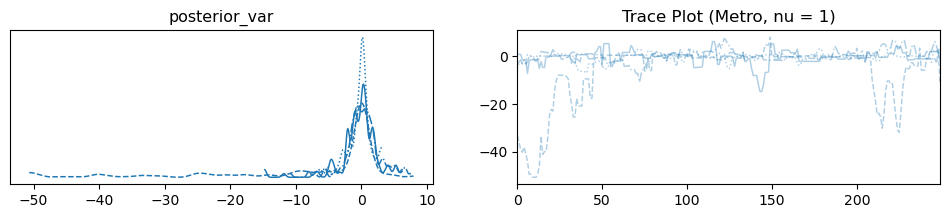

Running HMC with nu = 1


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


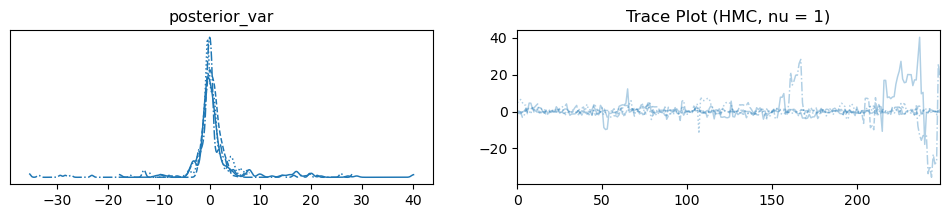

Running DEMetro with nu = 1


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


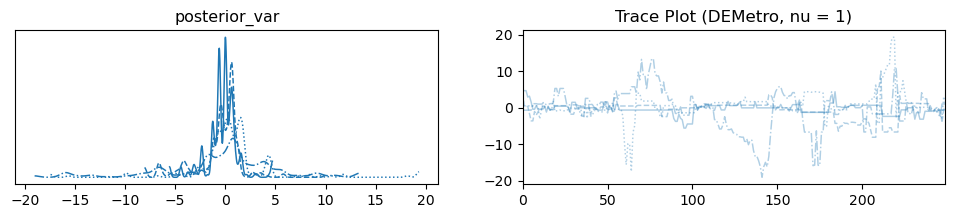

Running Metro with nu = 3


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


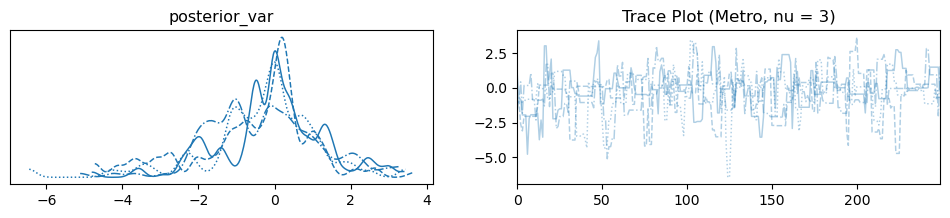

Running HMC with nu = 3


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


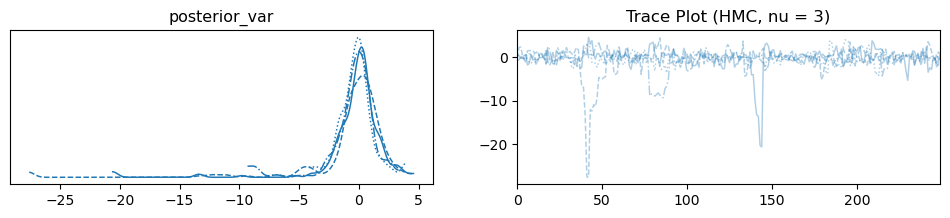

Running DEMetro with nu = 3


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


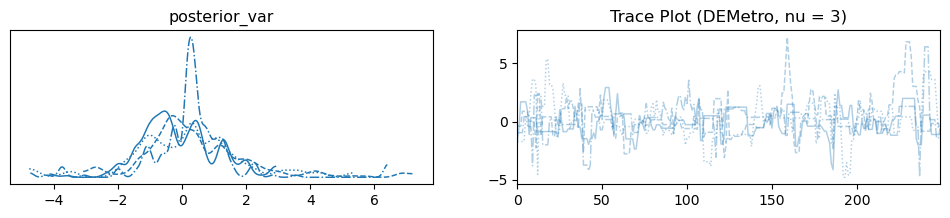


===== Running Student_t - Run 2 =====

Running Metro with nu = 1


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


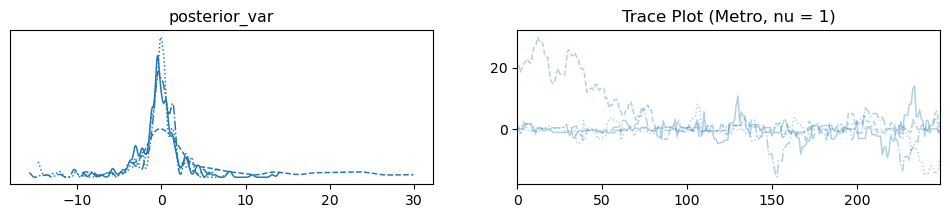

Running HMC with nu = 1


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


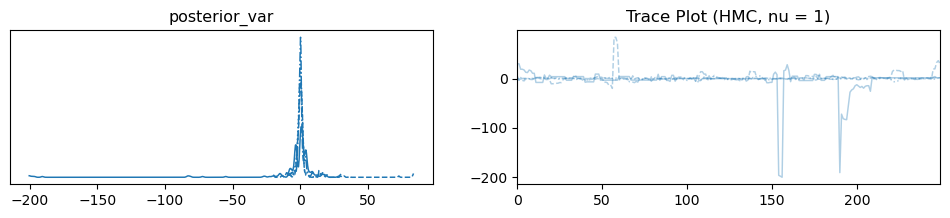

Running DEMetro with nu = 1


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


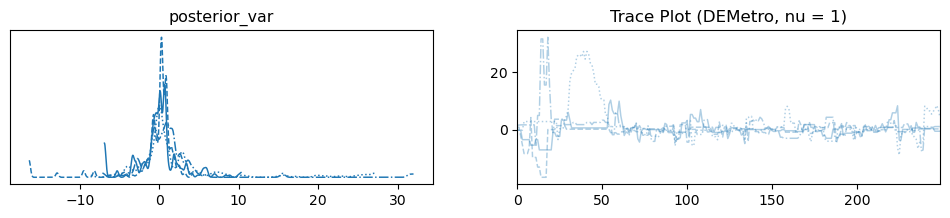

Running Metro with nu = 3


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


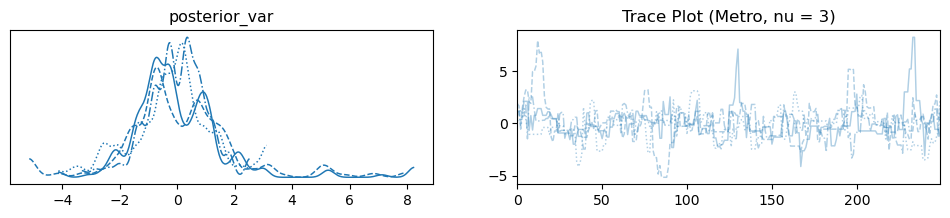

Running HMC with nu = 3


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


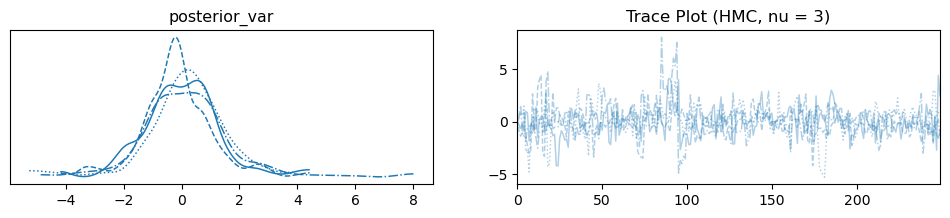

Running DEMetro with nu = 3


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


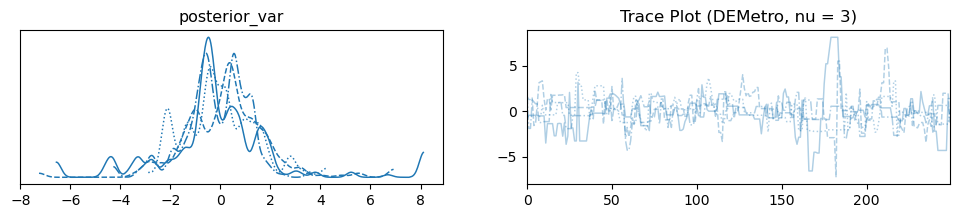


===== All Runs Completed Successfully! =====


===== Config Student_t Completed Successfully! =====


===== Config Laplace_test started! =====

Using IID sample settings: {'mu': 0, 'b': 'varies'}
Generating Laplace samples... {'mu': 0, 'b': 2}
Generating Laplace samples... {'mu': 0, 'b': 20}

===== Running Laplace_test - Run 1 =====

Running Metro with b = 2


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


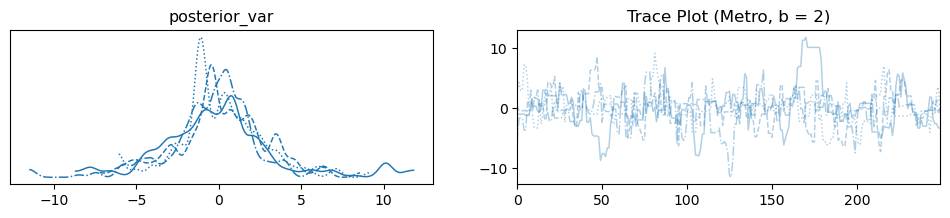

Running HMC with b = 2


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


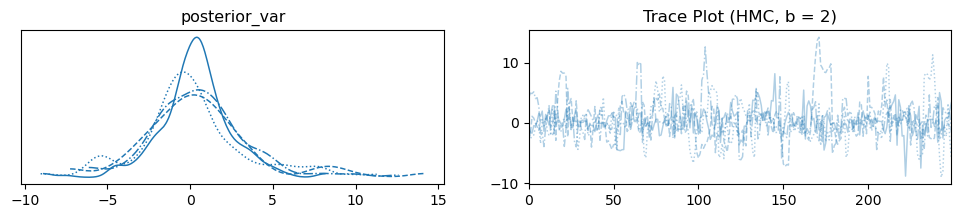

Running DEMetro with b = 2


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


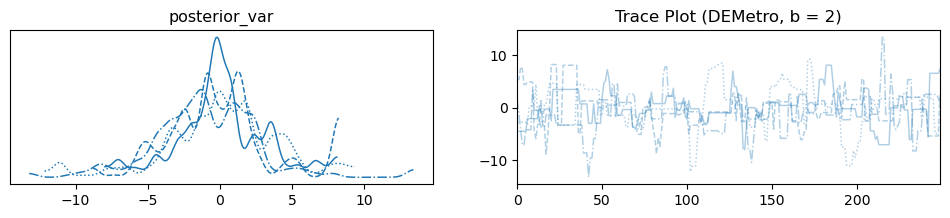

Running Metro with b = 20


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


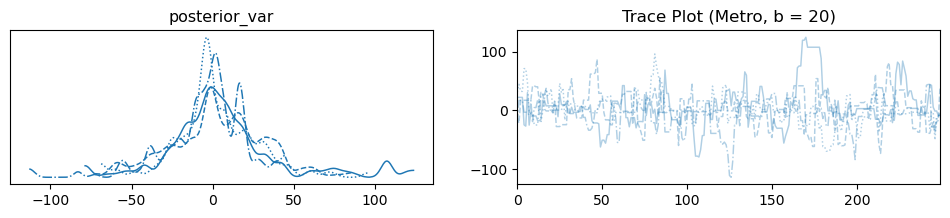

Running HMC with b = 20


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


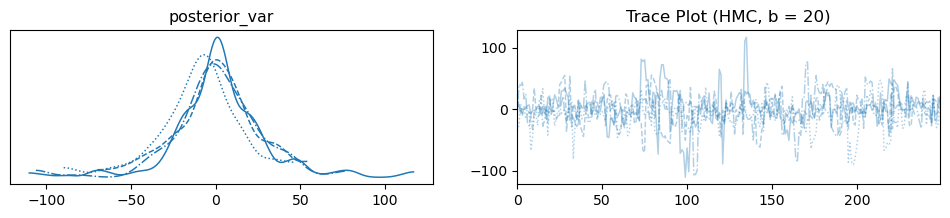

Running DEMetro with b = 20


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


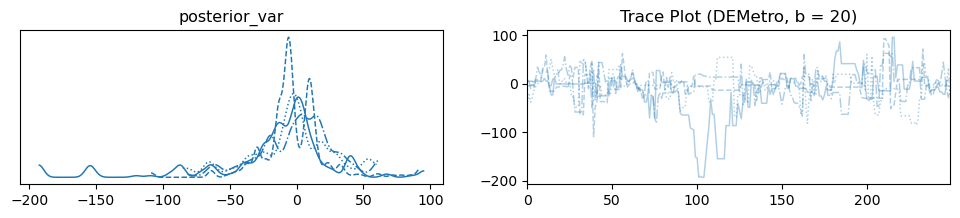


===== Running Laplace_test - Run 2 =====

Running Metro with b = 2


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


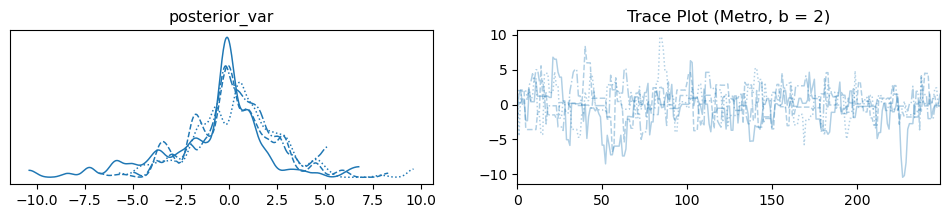

Running HMC with b = 2


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


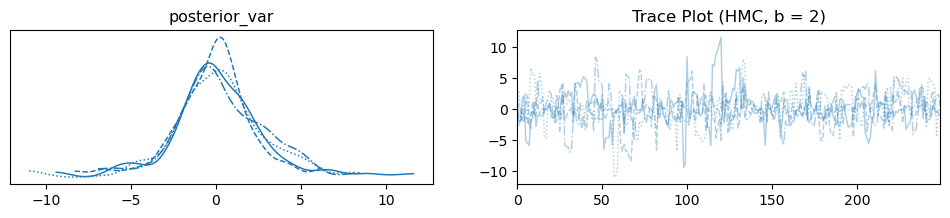

Running DEMetro with b = 2


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


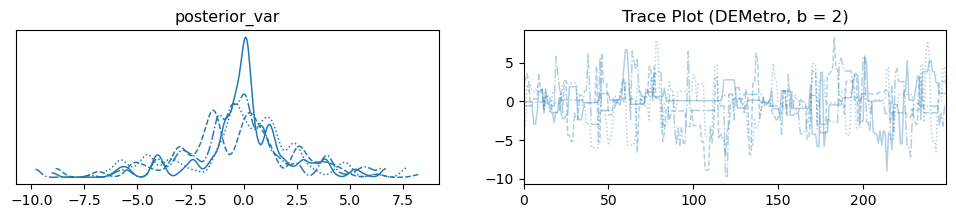

Running Metro with b = 20


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


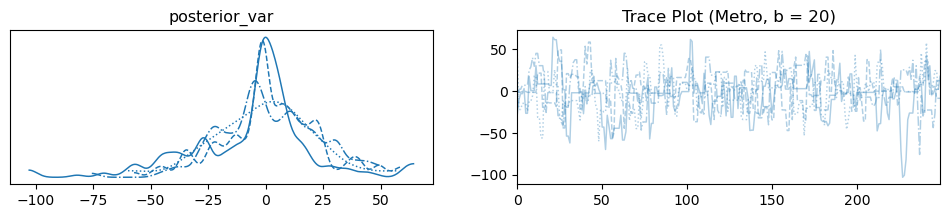

Running HMC with b = 20


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


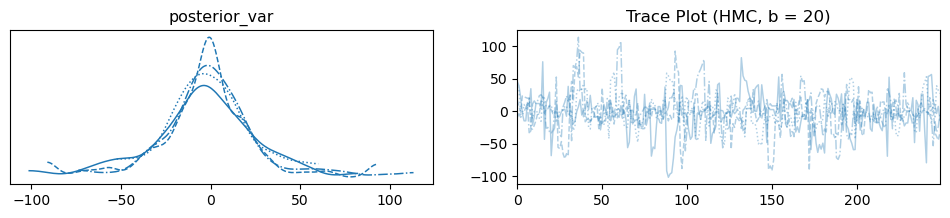

Running DEMetro with b = 20


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


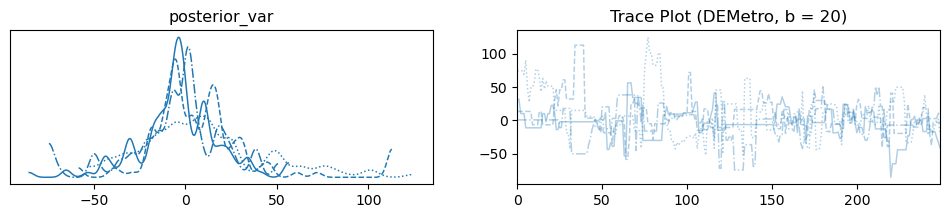


===== All Runs Completed Successfully! =====


===== Config Laplace_test Completed Successfully! =====


===== Config Mv_normal_3d_high_corr started! =====

Using IID sample settings: {'mu': 'varies', 'cov': [[1, 0.9, 0.85], [0.9, 1, 0.88], [0.85, 0.88, 1]]}
Generating MvNormal samples... {'mu': (-50, 0, 50), 'cov': [[1, 0.9, 0.85], [0.9, 1, 0.88], [0.85, 0.88, 1]]}
Skipping plotting: Multivariate Normal with dimension 3.
Generating MvNormal samples... {'mu': (43, 21, 1500), 'cov': [[1, 0.9, 0.85], [0.9, 1, 0.88], [0.85, 0.88, 1]]}
Skipping plotting: Multivariate Normal with dimension 3.

===== Running Mv_normal_3d_high_corr - Run 1 =====

Running Metro with mu = (-50, 0, 50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

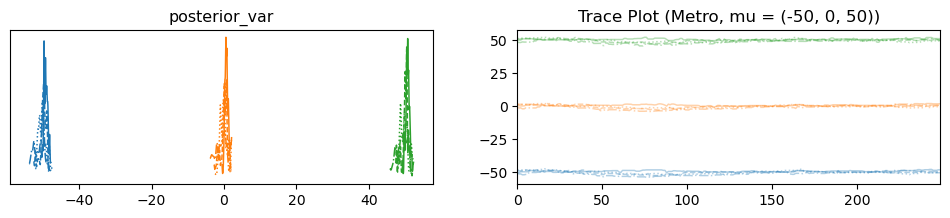

Running HMC with mu = (-50, 0, 50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


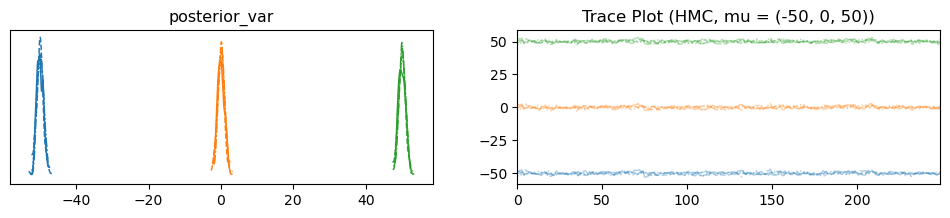

Running DEMetro with mu = (-50, 0, 50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


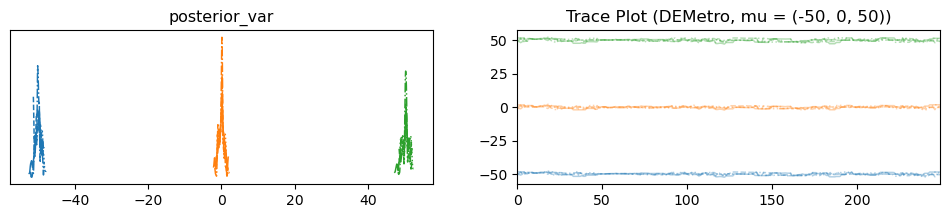

Running Metro with mu = (43, 21, 1500)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


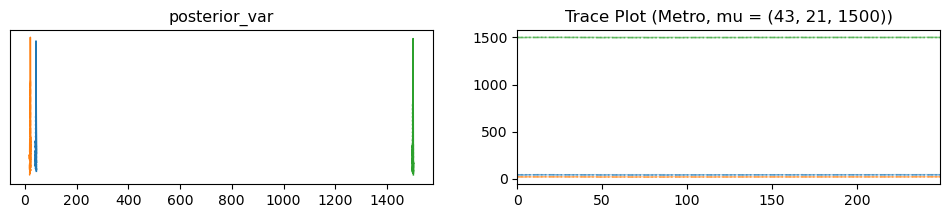

Running HMC with mu = (43, 21, 1500)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


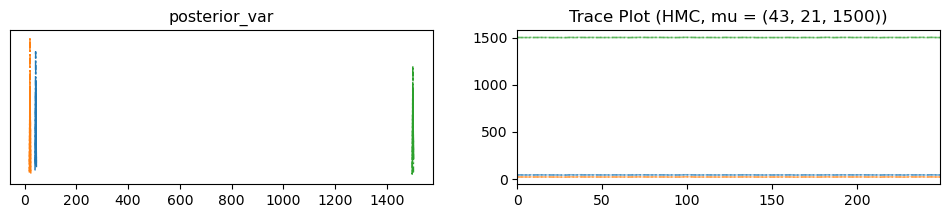

Running DEMetro with mu = (43, 21, 1500)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


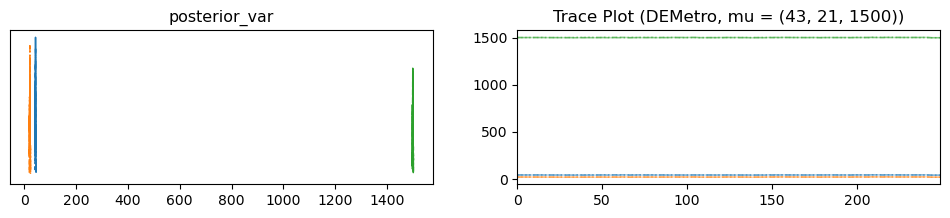


===== Running Mv_normal_3d_high_corr - Run 2 =====

Running Metro with mu = (-50, 0, 50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


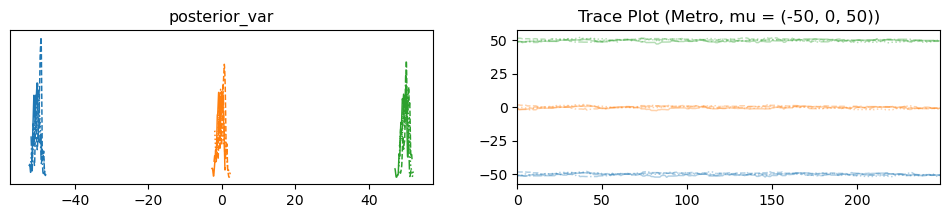

Running HMC with mu = (-50, 0, 50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


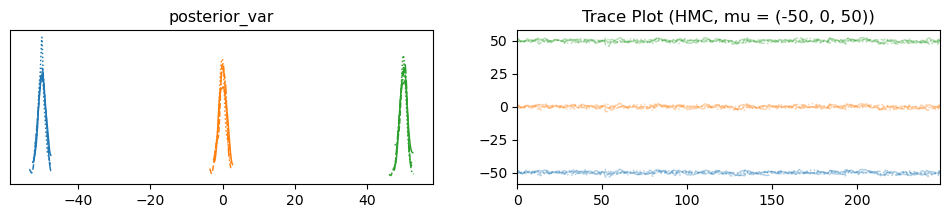

Running DEMetro with mu = (-50, 0, 50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


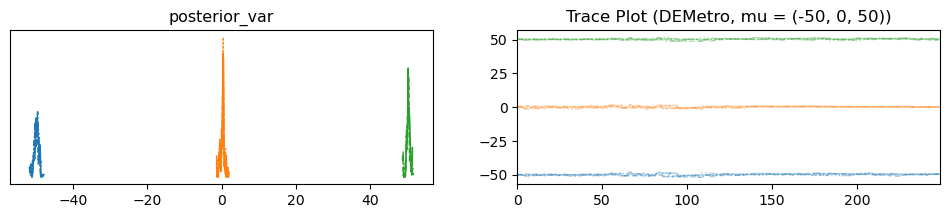

Running Metro with mu = (43, 21, 1500)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


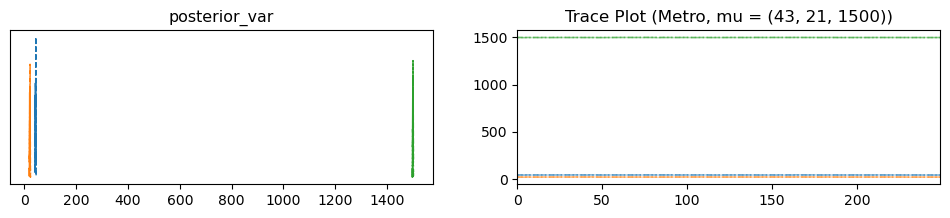

Running HMC with mu = (43, 21, 1500)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


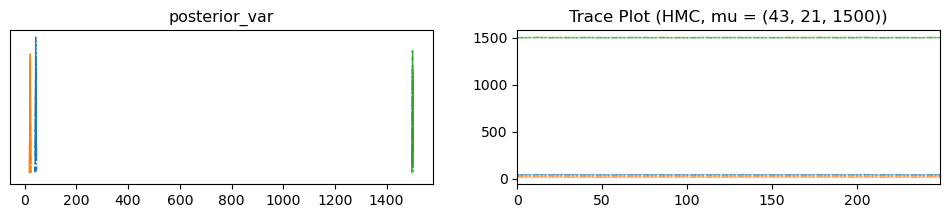

Running DEMetro with mu = (43, 21, 1500)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


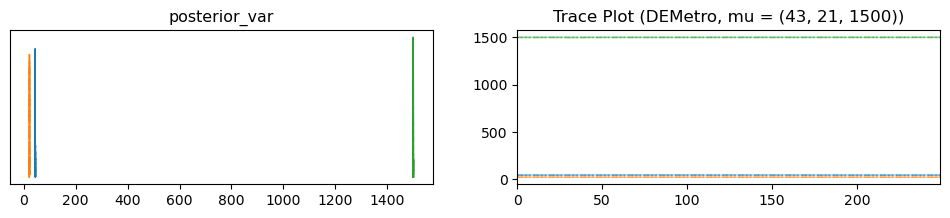


===== All Runs Completed Successfully! =====


===== Config Mv_normal_3d_high_corr Completed Successfully! =====


===== Config Mv_normal_2d_low_corr started! =====

Using IID sample settings: {'mu': 'varies', 'cov': [[1, 0.1], [0.1, 1]]}
Generating MvNormal samples... {'mu': (10, -20), 'cov': [[1, 0.1], [0.1, 1]]}
Generating MvNormal samples... {'mu': (50, -50), 'cov': [[1, 0.1], [0.1, 1]]}

===== Running Mv_normal_2d_low_corr - Run 1 =====

Running Metro with mu = (10, -20)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


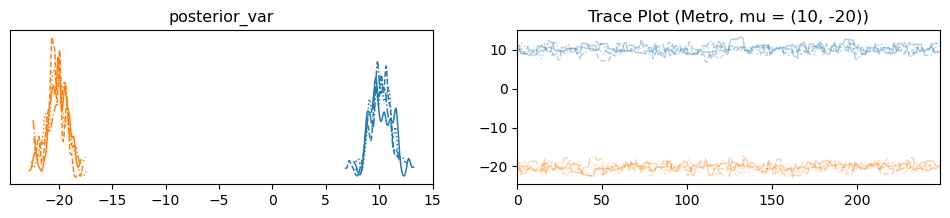

Running HMC with mu = (10, -20)


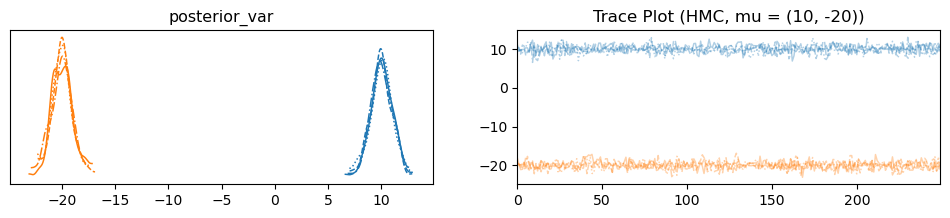

Running DEMetro with mu = (10, -20)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


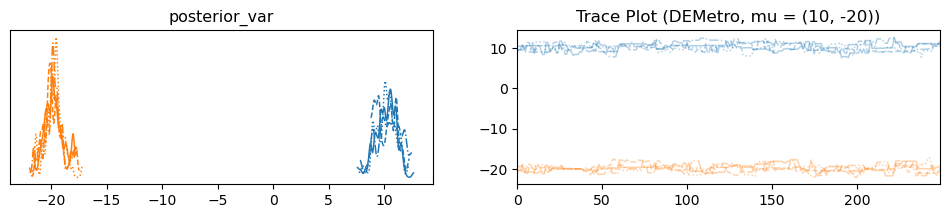

Running Metro with mu = (50, -50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


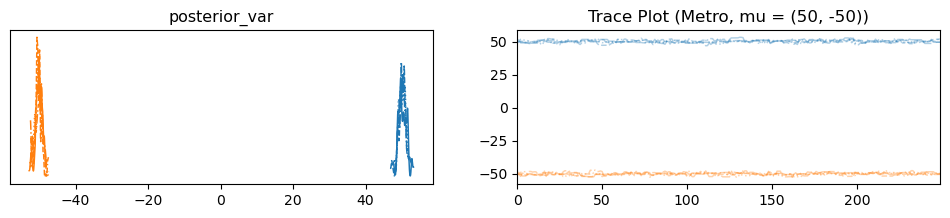

Running HMC with mu = (50, -50)


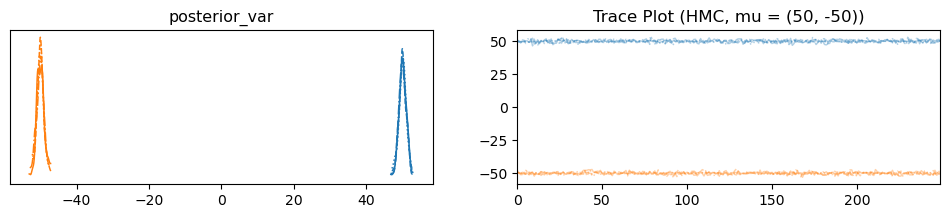

Running DEMetro with mu = (50, -50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


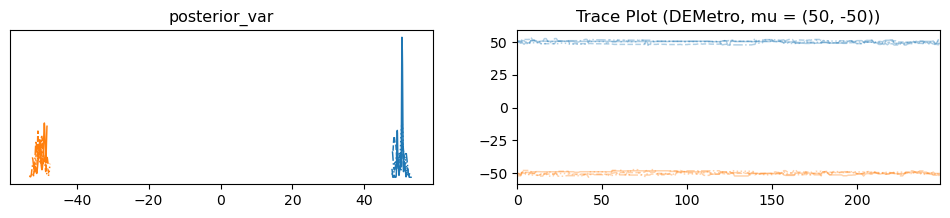


===== Running Mv_normal_2d_low_corr - Run 2 =====

Running Metro with mu = (10, -20)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


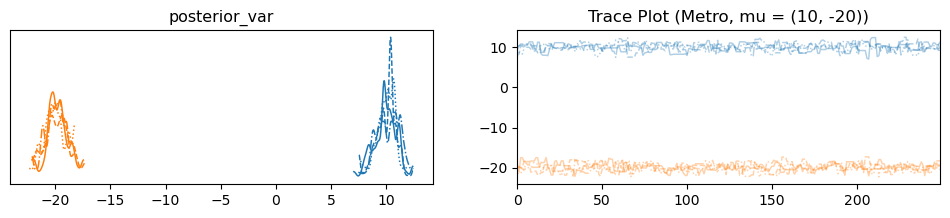

Running HMC with mu = (10, -20)


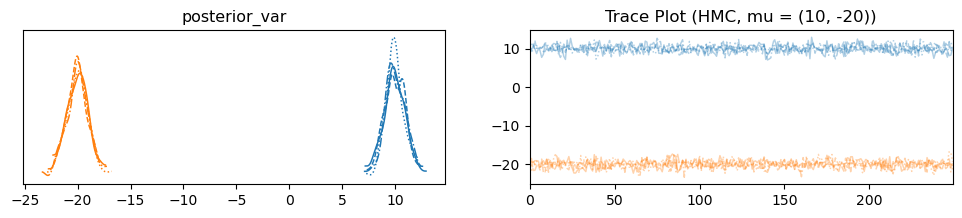

Running DEMetro with mu = (10, -20)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


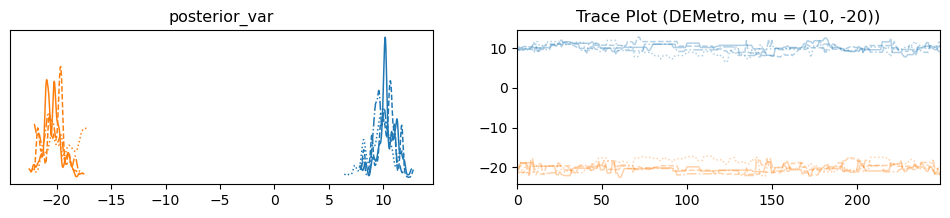

Running Metro with mu = (50, -50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


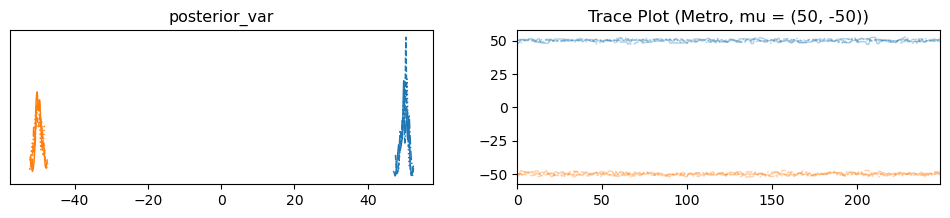

Running HMC with mu = (50, -50)


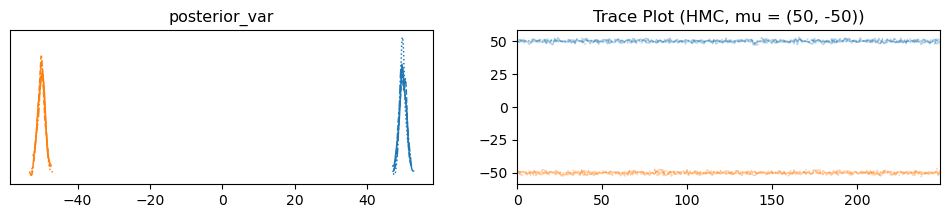

Running DEMetro with mu = (50, -50)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


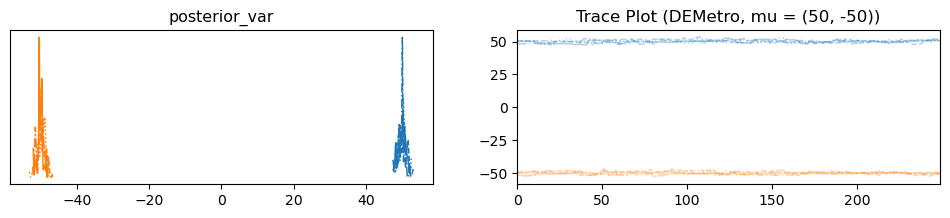


===== All Runs Completed Successfully! =====


===== Config Mv_normal_2d_low_corr Completed Successfully! =====


===== Config Mv_normal_2d_high_corr started! =====

Using IID sample settings: {'mu': [10, -20], 'cov': [[1, 0.95], [0.95, 1]]}
Generating MvNormal samples... {'mu': [10, -20], 'cov': [[1, 0.95], [0.95, 1]]}

===== Running Mv_normal_2d_high_corr - Run 1 =====

Running Metro with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


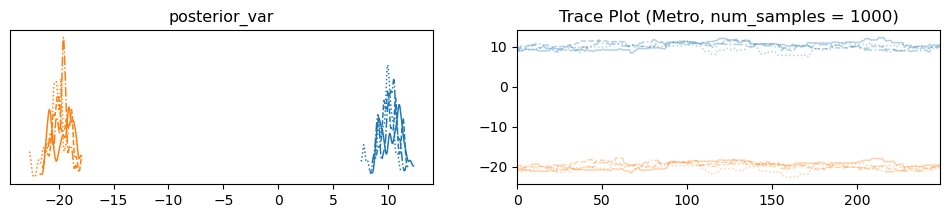

Running HMC with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


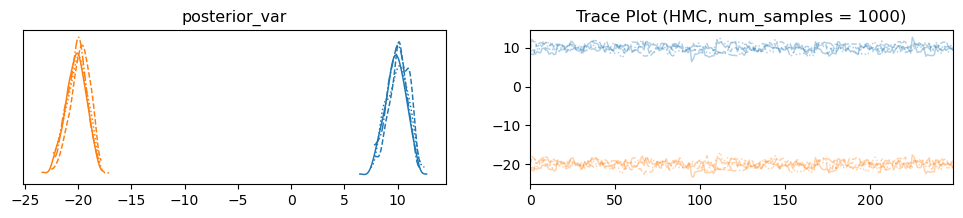

Running DEMetro with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


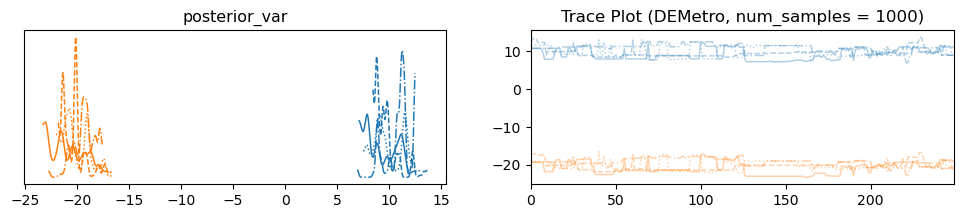


===== Running Mv_normal_2d_high_corr - Run 2 =====

Running Metro with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


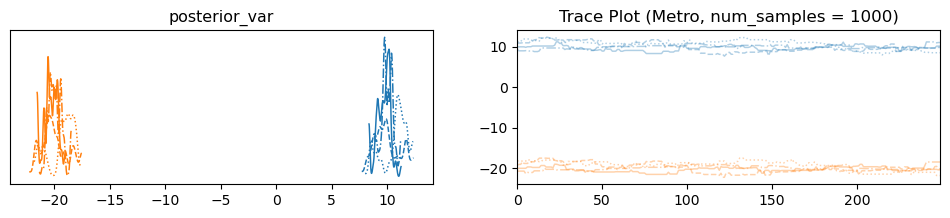

Running HMC with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


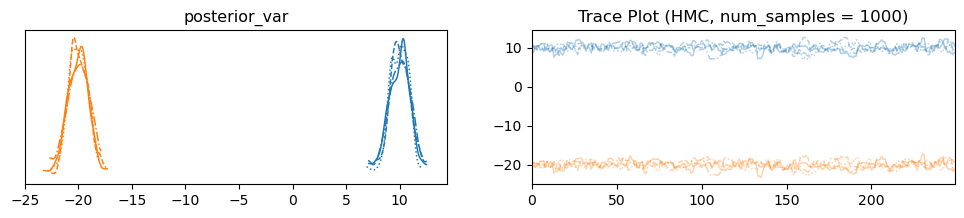

Running DEMetro with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


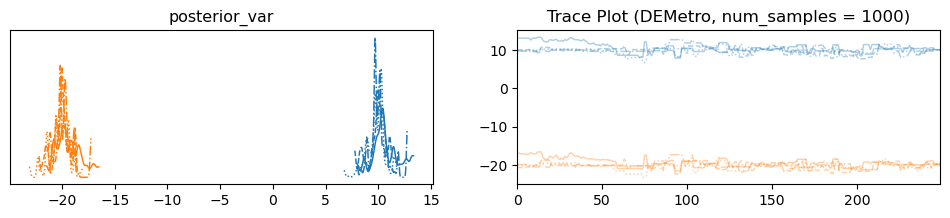


===== All Runs Completed Successfully! =====


===== Config Mv_normal_2d_high_corr Completed Successfully! =====


===== Config Mv_normal_3d_low_corr started! =====

Using IID sample settings: {'mu': [-50, 0, 50], 'cov': [[1, 0.2, 0.1], [0.2, 1, 0.15], [0.1, 0.15, 1]]}
Generating MvNormal samples... {'mu': [-50, 0, 50], 'cov': [[1, 0.2, 0.1], [0.2, 1, 0.15], [0.1, 0.15, 1]]}
Skipping plotting: Multivariate Normal with dimension 3.

===== Running Mv_normal_3d_low_corr - Run 1 =====

Running Metro with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<Figure size 800x600 with 0 Axes>

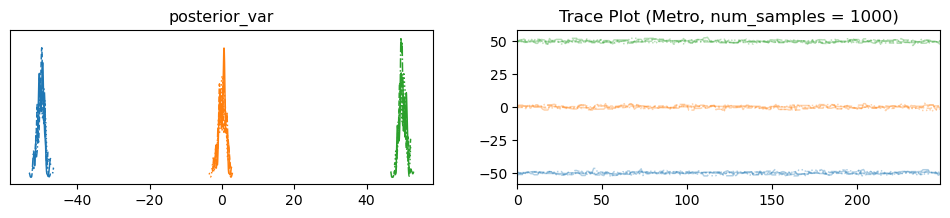

Running HMC with num_samples = 1000


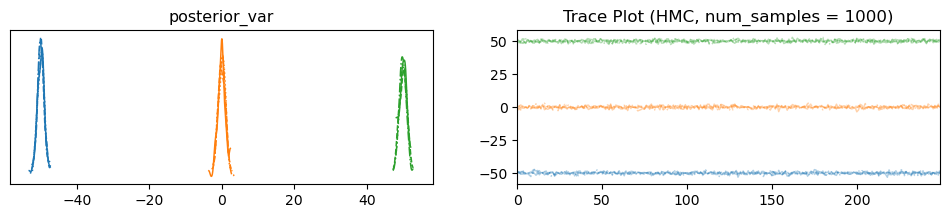

Running DEMetro with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


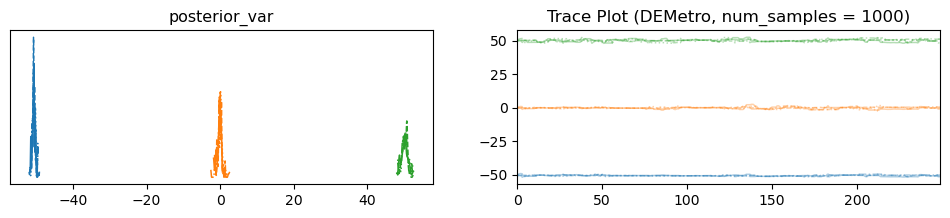


===== Running Mv_normal_3d_low_corr - Run 2 =====

Running Metro with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


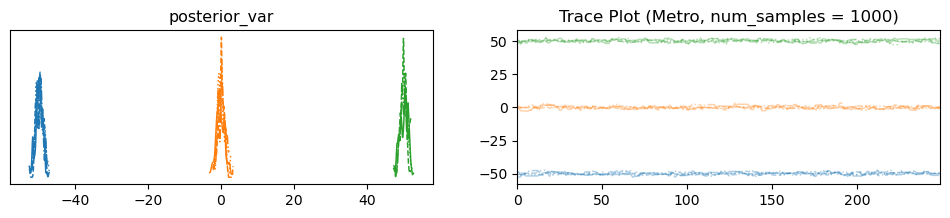

Running HMC with num_samples = 1000


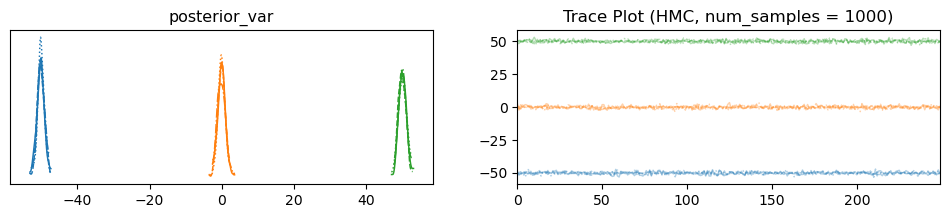

Running DEMetro with num_samples = 1000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


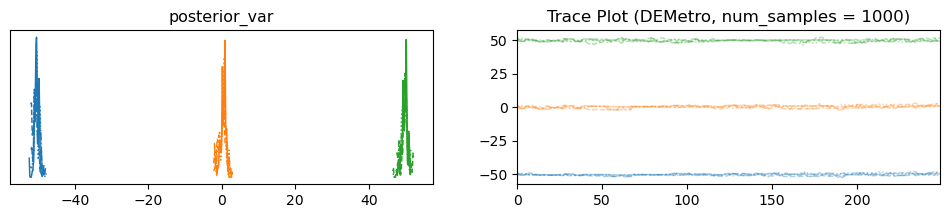


===== All Runs Completed Successfully! =====


===== Config Mv_normal_3d_low_corr Completed Successfully! =====


===== Config Mv_normal_2d_mixture_3_comp started! =====

Using IID sample settings: {'component_types': ['MvNormal', 'MvNormal', 'MvNormal'], 'component_params': [{'mu': [0, 0], 'cov': [[1, 0.5], [0.5, 1]]}, {'cov': [[2, 0.3], [0.3, 2]]}, {'mu': [-10, -10], 'cov': [[1, -0.2], [-0.2, 1]]}], 'weights': [0.3, 0.4, 0.3]}
Updating component 1 with mu = (10, -30)
Posterior dimension: 2
Generating MvNormal samples... {'mu': [0, 0], 'cov': [[1, 0.5], [0.5, 1]]}
Generating MvNormal samples... {'cov': [[2, 0.3], [0.3, 2]], 'mu': (10, -30)}
Generating MvNormal samples... {'mu': [-10, -10], 'cov': [[1, -0.2], [-0.2, 1]]}
Updating component 1 with mu = (20, 1000)
Posterior dimension: 2
Generating MvNormal samples... {'mu': [0, 0], 'cov': [[1, 0.5], [0.5, 1]]}
Generating MvNormal samples... {'cov': [[2, 0.3], [0.3, 2]], 'mu': (20, 1000)}
Generating MvNormal samples... {'mu': [-10, -10],

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


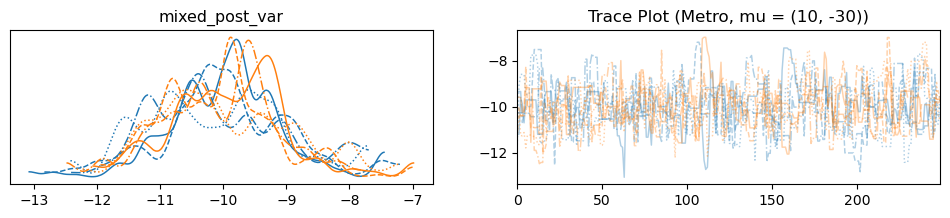

Running HMC with mu = (10, -30) (Component 1)


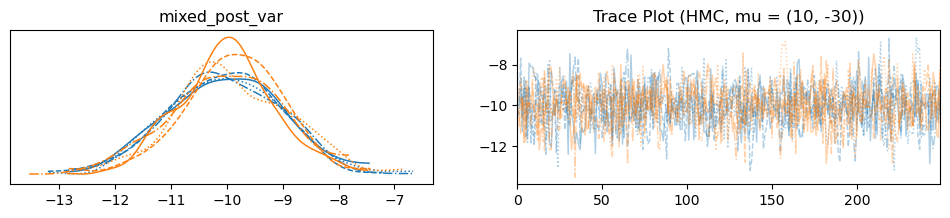

Running DEMetro with mu = (10, -30) (Component 1)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


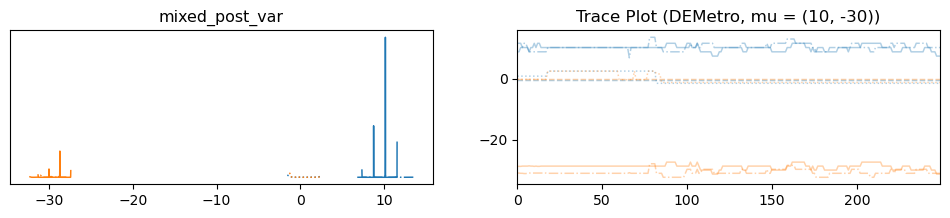

Component index: 1
Running Metro with mu = (20, 1000) (Component 1)


KeyboardInterrupt: 

In [60]:


categories = [unimodal, high_dim_and_correlated, multimodal, difficult_geometries]

experiment_name = "gonna_test_em_all"

# Define the root directory for all experiments
experiment_root_folder = f"exp_{experiment_name}"

# Check if the folder already exists
if os.path.exists(experiment_root_folder):
    user_input = input(
        f"Folder '{experiment_root_folder}' already exists and will be overwritten.\n"
        "Do you want to continue? (yes/no): "
    ).strip().lower()

    if user_input not in ["yes", "y"]:
        print("Operation aborted. No files were deleted.")
        exit()  # Stop execution
    
    shutil.rmtree(experiment_root_folder)

create_directories(experiment_root_folder)

plot_traces_in_notebook = False

# need to adapt validation of config
#for config in experiment:
#    validate_config(config)

#print("All configurations are valid. Starting experiments...")

for category in categories:
    for config in category:
        try:
            run_experiment(
                plot_traces_in_notebook=plot_traces_in_notebook,
                posterior_type=config["posterior_type"],
                config_descr=config["config_descr"],
                runs=config["runs"],
                varying_attribute=config["varying_attribute"],
                varying_values=config["varying_values"],
                init_scheme="varies" if config["varying_attribute"] == "init_scheme" else config.get("init_scheme", None),
                num_samples="varies" if config["varying_attribute"] == "num_samples" else config["num_samples"],
                num_chains="varies" if config["varying_attribute"] == "num_chains" else config["num_chains"],
                base_random_seed=config.get("base_random_seed", None),
                **{k: v for k, v in config.items() if k not in [
                    "config_descr", "runs", "varying_attribute", "varying_values", 
                    "num_samples", "num_chains", "init_scheme", 
                    "base_random_seed", "posterior_type"
                ]}  # Pass remaining keys as posterior_kwargs
            )
        except Exception as e:
            print(f"❌ Error in config '{config['config_descr']}': {e}")

print("All experiments completed successfully!")


In [ ]:
Test_all_inference_attr = [

    {
        "config_descr": "Samples_test",
        "posterior_type": "bimodal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",    
        "varying_values": [100, 200, 300],
        "mode_means": (3,-3),
        "std_of_modes": (1,1),
        "weights": (1,1)
    },
    
    {
        "config_descr": "Chains_test",
        "posterior_type": "bimodal",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_chains",    
        "varying_values": [4,6,8],
        "mode_means": (3,-3),
        "std_of_modes": (1,1),
        "weights": (1,1)
    }
    #add init scheme test

    #add burn in as well?
    ]


# Can select any of the posterior_type kwargs to vary, e.g., for a normal distribution, mu or sigma can be varied
Test_all_posterior_types = [

    {
        "config_descr": "Normal_test",
        "posterior_type": "normal",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [0, 1, 2],
        "sigma": 1
    },

    {
        "config_descr": "Beta_test",
        "posterior_type": "beta",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "a",
        "varying_values": [0.5,5,1],
        "b": 3,
    },

    {
        "config_descr": "Cauchy_test",
        "posterior_type": "cauchy",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "loc",
        "varying_values": [0, -2, 5],
        "scale": 1,
    },

    {
        "config_descr": "Laplace_test",
        "posterior_type": "laplace",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "b",
        "varying_values": [1, 2, 3, 20],
        "mu": 0,
    },

    {
        "config_descr": "Student_t_test",
        "posterior_type": "student_t",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains":  default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "nu",
        "varying_values": [1, 2, 3],
        "mu": 0,
        "sigma": 1,
    },
    {
        "config_descr": "Skewed_student_t_test",
        "posterior_type": "skewed_student_t",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "a",
        "varying_values": [0.5, 1, 2],
        "b": 1,
        "mu": 0,
        "sigma": 1,
    },

    {
        "config_descr": "Bimodal_test",
        "posterior_type": "bimodal",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mode_means",
        "varying_values": [(0,0), (1,1), (2,2)],
        "std_of_modes": (1,1),
        "weights": (1,1),
    }

]



test_triple_normal = [
    
    {
        "config_descr": "Mixture_test",
        "posterior_type": "mixture",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000, 2000, 8000],
        "component_types": ["normal", "normal", "normal"],
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 10, "sigma": 1}, {"mu": -40, "sigma": 1}],
        "weights": [0.3, 0.5, 0.2]  # Uneven weighting
    }
]


test_normal_and_student_t = [
    
    {   
        "config_descr": "Mixture_test",
        "posterior_type": "mixture",
        "component_types": ["normal", "student_t"],
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [10000],
        "component_params": [{"mu": 0, "sigma": 1}, {"nu": 3, "mu": 5, "sigma": 2}],
        "weights": [0.6, 0.4]
        }
]

test_mvnormal_2d_mixture = [

    {
        "config_descr": "MVNormal_mixture",
        "posterior_type": "mixture",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "component_types": ["mv_normal", "mv_normal", "mv_normal"],
        "component_params": [
                {"mu": [0, 0], "cov": [[1, 0.5], [0.5, 1]]},   # First component
                {"mu": [10, 10], "cov": [[2, 0.3], [0.3, 2]]},  # Second component
                {"mu": [-10, -10], "cov": [[1, -0.2], [-0.2, 1]]}  # Third component
        ],
        "weights": [0.3, 0.4, 0.3]
    }
        
]

test_mvnormal = [
    {
        "config_descr": "MVNormal_test",
        "posterior_type": "mv_normal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "mu": [10, -20],
        #"cov": [[1, 0.5], [0.5, 1]]
        "cov": [[1, 0.95], [0.95, 1]]  # Very strong correlation,
    }
]

test_3d_normal = [

    {
        "config_descr": "MVNormal_test",
        "posterior_type": "mv_normal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "mu":  [-50, 0, 50],
        "cov":  [[1, 0.8, 0.3], [0.8, 1, 0.4], [0.3, 0.4, 1]]  # Works (3D Normal)

    }   

]

#Test_custom = [
#    {
#        "config_descr": "custom_gaussian_mixture",
#        "posterior_type": "custom",
#        "runs": 5,
#        "num_samples": default_num_samples,
#        "num_chains": default_num_chains,
#        "base_random_seed": 42,
#        #"logp_func": my_custom_logp_function,  # Custom function
#        #"priors": {"x": pm.Uniform.dist(lower=-10, upper=10)}
#    }
#]

In [103]:
# old boilerplate code
# initialize plots for all samplers
        fig_ws, ax_ws = plt.subplots(figsize=(10, 6))
        fig_rhat, ax_rhat = plt.subplots(figsize=(10, 6))
        fig_ess, ax_ess = plt.subplots(figsize=(10, 6))
        fig_time, ax_time = plt.subplots(figsize=(10, 6))

        for sampler in df_results["sampler"].unique():
            df_sampler = df_results[df_results["sampler"] == sampler]
            csv_filename = os.path.join(results_folder, f"{sampler}_results.csv")
            df_sampler.to_csv(csv_filename, index=False)

            # Plot Wasserstein Distance
            ax_ws.plot(df_sampler[varying_attribute_for_plot], df_sampler["wasserstein_distance"], 
                marker="o", linestyle="-", label=sampler, 
                color=sampler_colors.get(sampler, "black"))

            # Plot R-hat values
            ax_rhat.plot(df_sampler[varying_attribute_for_plot], df_sampler["r_hat"], 
                    marker="o", linestyle="-", label=sampler, 
                    color=sampler_colors.get(sampler, "black"))
            
            # Plot ESS values
            ax_ess.plot(df_sampler[varying_attribute_for_plot], df_sampler["ess"], 
                    marker="o", linestyle="-", label=sampler, 
                    color=sampler_colors.get(sampler, "black"))

            # **Plot Computation Time**
            ax_time.plot(df_sampler[varying_attribute_for_plot], df_sampler["runtime"], 
                        marker="o", linestyle="-", label=sampler, 
                        color=sampler_colors.get(sampler, "black"))
            
        
        # Set dynamic axis labels and titles
        attribute_label = "Mode Distance" if varying_attribute == "mode_means" else varying_attribute.replace("_", " ").title()
        
        # ===== Finalize and Save Wasserstein Plot =====
        ax_ws.set_xlabel(attribute_label)
        ax_ws.set_ylabel("Wasserstein Distance")
        ax_ws.set_title(f"Wasserstein Distance for Samplers (config =_{config_descr})")
        ax_ws.legend(title="Sampler")
        ax_ws.grid(True)
        plot_filename = os.path.join(plots_folder, f"Wasserstein_run_{run_id}.pdf")
        fig_ws.savefig(plot_filename, bbox_inches="tight")
        plt.close(fig_ws)

        # ===== Finalize and Save R-hat Plot =====
        ax_rhat.set_xlabel(attribute_label)
        ax_rhat.set_ylabel("R-hat")
        ax_rhat.set_title(f"R-hat for Samplers (config =_{config_descr})")
        ax_rhat.legend(title="Sampler")
        ax_rhat.grid(True)
        rhat_plot_filename = os.path.join(plots_folder, f"R-hat_run_{run_id}.pdf")
        fig_rhat.savefig(rhat_plot_filename, bbox_inches="tight")
        plt.close(fig_rhat)

        # ===== Finalize and Save ESS Plot =====
        ax_ess.set_xlabel(attribute_label)
        ax_ess.set_ylabel("ESS")
        ax_ess.set_title(f"ESS for Samplers (config =_{config_descr})")
        ax_ess.legend(title="Sampler")
        ax_ess.grid(True)
        ess_plot_filename = os.path.join(plots_folder, f"ESS_run_{run_id}.pdf")
        fig_ess.savefig(ess_plot_filename, bbox_inches="tight")
        plt.close(fig_ess)

        # ===== Finalize and Save Time Plot =====
        ax_time.set_xlabel(attribute_label)
        ax_time.set_ylabel("Computation Time (seconds)")
        ax_time.set_title(f"Computation Time for Samplers (config =_{config_descr})")
        ax_time.legend(title="Sampler")
        ax_time.grid(True)
        time_plot_filename = os.path.join(plots_folder, f"ComputationTime_run_{run_id}.pdf")
        fig_time.savefig(time_plot_filename, bbox_inches="tight")
        plt.close(fig_time)



IndentationError: unexpected indent (3318593455.py, line 3)

In [ ]:
# old boilerplate code for global metrics

if varying_attribute == "mode_means":
        df_all_runs["mode_distance"] = df_all_runs[varying_attribute].apply(lambda x: abs(eval(x)[1] - eval(x)[0]))
        df_all_runs = df_all_runs.sort_values("mode_distance", ascending=True)
        varying_attribute_for_global_plot = "mode_distance"
    else:
        df_all_runs = df_all_runs.sort_values(varying_attribute, ascending=True)
        varying_attribute_for_global_plot = varying_attribute


    # Initialize global plots
    fig_ws, ax_ws = plt.subplots(figsize=(10, 6))
    fig_rhat, ax_rhat = plt.subplots(figsize=(10, 6))
    fig_ess, ax_ess = plt.subplots(figsize=(10, 6))
    fig_time, ax_time = plt.subplots(figsize=(10, 6)) 

    for sampler in ["Metro", "HMC", "DEMetro"]:
        df_sampler = df_all_runs[df_all_runs["sampler"] == sampler]
        color = sampler_colors.get(sampler, "black")







        # Pivot tables: rows = varying attribute, columns = run_id, values = metrics
        df_ws = df_sampler.pivot_table(index=varying_attribute_for_global_plot, columns="run_id", values="wasserstein_distance")
        df_rhat = df_sampler.pivot_table(index=varying_attribute_for_global_plot, columns="run_id", values="r_hat")
        df_ess = df_sampler.pivot_table(index=varying_attribute_for_global_plot, columns="run_id", values="ess")
        df_time = df_sampler.pivot_table(index=varying_attribute, columns="run_id", values="runtime")
    
        # Compute mean and standard deviation for error bars
        ws_mean, ws_std = df_ws.mean(axis=1), df_ws.std(axis=1)
        rhat_mean, rhat_std = df_rhat.mean(axis=1), df_rhat.std(axis=1)
        ess_mean, ess_std = df_ess.mean(axis=1), df_ess.std(axis=1)
        time_mean, time_std = df_time.mean(axis=1), df_time.std(axis=1)

        # Plot with error bars
        ax_ws.errorbar(ws_mean.index, ws_mean, yerr=ws_std, fmt="o-", label=sampler, color=color, capsize=5)
        ax_rhat.errorbar(rhat_mean.index, rhat_mean, yerr=rhat_std, fmt="o-", label=sampler, color=color, capsize=5)
        ax_ess.errorbar(ess_mean.index, ess_mean, yerr=ess_std, fmt="o-", label=sampler, color=color, capsize=5)
        ax_time.errorbar(time_mean.index, time_mean, yerr=time_std, fmt="o-", label=sampler, color=color, capsize=5)

        # Save global averages 
        df_global_avg = pd.DataFrame({
            varying_attribute: ws_mean.index,
            "global_avg_ws": ws_mean.values,
            "global_avg_ws_std": ws_std.values,
            "global_avg_rhat": rhat_mean.values,
            "global_avg_rhat_std": rhat_std.values,
            "global_avg_ess": ess_mean.values,
            "global_avg_ess_std": ess_std.values,
            "global_avg_time": time_mean.values,
            "global_avg_time_std": time_std.values
        })

















        sampler_csv_filename = os.path.join(global_results_folder, f"Global_results_{sampler}.csv")
        df_global_avg.to_csv(sampler_csv_filename, index=False)


    # ===== Save Global Wasserstein Plot =====
    ax_ws.set_xlabel(attribute_label)
    ax_ws.set_ylabel("Average Wasserstein Distance")
    ax_ws.set_title(f"Averaged Wasserstein Distance ({runs} Runs, config = {config_descr})")
    ax_ws.legend(title="Sampler")
    ax_ws.grid(True)
    fig_ws.savefig(os.path.join(global_plots_folder, "Wasserstein_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_ws)

    # ===== Save Global R-hat Plot =====
    ax_rhat.set_xlabel(attribute_label)
    ax_rhat.set_ylabel("Average R-hat")
    ax_rhat.set_title(f"Averaged R-hat Values ({runs} Runs, config = {config_descr})")
    ax_rhat.legend(title="Sampler")
    ax_rhat.grid(True)
    fig_rhat.savefig(os.path.join(global_plots_folder, "Rhat_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_rhat)

    # ===== Save Global ESS Plot =====
    ax_ess.set_xlabel(attribute_label)
    ax_ess.set_ylabel("Average ESS")
    ax_ess.set_title(f"Averaged ESS ({runs} Runs,  config = {config_descr})")
    ax_ess.legend(title="Sampler")
    ax_ess.grid(True)
    fig_ess.savefig(os.path.join(global_plots_folder, "ESS_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_ess)

    # ===== Save Global Time Plot =====
    ax_time.set_xlabel(attribute_label)
    ax_time.set_ylabel("Average Computation Time (seconds)")
    ax_time.set_title(f"Averaged Computation Time ({runs} Runs, config = {config_descr})")
    ax_time.legend(title="Sampler")
    ax_time.grid(True)
    fig_time.savefig(os.path.join(global_plots_folder, "Time_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_time)